In [1]:
import os
# Deshabilita la GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  

# Suprime los logs de TensorFlow relacionados con errores e información
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"  

# Suprime las advertencias para una salida más limpia
import warnings
warnings.filterwarnings('ignore')

# Importa TensorFlow y Keras
import tensorflow as tf
import keras

# Imprime las versiones de TensorFlow y Keras instaladas en el entorno
print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")

E0000 00:00:1732227300.558734   12784 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732227300.563651   12784 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow version: 2.18.0
Keras version: 3.6.0


In [2]:
# Importación de módulos estándar
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Importación de módulos de Keras para construcción de modelos de redes neuronales
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Input
from keras import regularizers
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
from keras import metrics

# Importación de módulos de scikit-learn para preprocesamiento y evaluación de modelos
from sklearn.model_selection import KFold, train_test_split, cross_validate, cross_val_score
from sklearn.metrics import (mean_squared_error, recall_score, precision_score, 
                             accuracy_score, f1_score, confusion_matrix, precision_recall_curve)
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Importación del módulo time para medir tiempos de ejecución
from time import time

# Configuración de semillas aleatorias para reproducibilidad
np.random.seed(7)
seed = 15
rng = np.random.RandomState(313)

# Configuración para visualizar gráficos en línea en Jupyter Notebook
%matplotlib inline



## Carga y Exploración de los Datos

En esta sección, cargamos los conjuntos de datos balanceados para entrenamiento y prueba, exploramos su composición y preparamos las características (`X`) y las etiquetas (`Y`) para el modelado.

#### Propósito
- Leer los datos desde archivos CSV.
- Verificar la distribución de clases en los conjuntos de datos balanceados.
- Separar las características (`X`) de las etiquetas (`Y`) para ambos conjuntos.

#### Resultados Observados

1. **Conjunto de Entrenamiento**:
   - Cantidad de observaciones por clase:
     - Clase `0` (sanos): 6,212 (50.06%)
     - Clase `1` (afectados): 6,196 (49.94%)
   - Dimensiones:
     - Características: (12,408 observaciones, 606 columnas)
     - Etiquetas: (12,408 observaciones)

2. **Conjunto de Prueba 1**:
   - Cantidad de observaciones por clase:
     - Clase `0` (sanos): 777 (50.10%)
     - Clase `1` (afectados): 774 (49.90%)
   - Dimensiones:
     - Características: (1,551 observaciones, 606 columnas)
     - Etiquetas: (1,551 observaciones)

#### Comentario
Este análisis inicial confirma que los conjuntos de datos están balanceados entre las clases y listos para el modelado. Las etiquetas (`CLASS_LABEL`) se manejan de forma separada para entrenar y evaluar modelos de clasificación binaria.


In [3]:
X_train = pd.read_csv(r"../Datos/BinarioTrainBalanced.csv")
X_test  = pd.read_csv(r"../Datos/BinarioTest1Balanced.csv")

In [4]:
print("\n\t\tDatos de entrenamiento")
nr_clases = X_train['CLASS_LABEL'].value_counts(sort=True)
print("\nCantidad ",nr_clases,"\nPorcentajes", nr_clases*100/X_train.shape[0])
Y_train = X_train['CLASS_LABEL']
X_train = X_train.drop(['CLASS_LABEL'], axis=1)
print(X_train.shape, Y_train.shape)

print("\n\t\tDatos de prueba")
nr_clases = X_test['CLASS_LABEL'].value_counts(sort=True)
print("\nCantidad ",nr_clases,"\nPorcentajes", nr_clases*100/X_test.shape[0])
Y_test = X_test['CLASS_LABEL']
X_test = X_test.drop(['CLASS_LABEL'], axis=1)
print(X_test.shape, Y_test.shape)


		Datos de entrenamiento

Cantidad  CLASS_LABEL
0    6212
1    6196
Name: count, dtype: int64 
Porcentajes CLASS_LABEL
0    50.064475
1    49.935525
Name: count, dtype: float64
(12408, 606) (12408,)

		Datos de prueba

Cantidad  CLASS_LABEL
0    777
1    774
Name: count, dtype: int64 
Porcentajes CLASS_LABEL
0    50.096712
1    49.903288
Name: count, dtype: float64
(1551, 606) (1551,)


  ## Crear MPL y Búsqueda de Hiperparámetros con Keras Tuner

  En esta sección, se define una red neuronal utilizando Keras y se emplea la biblioteca Keras Tuner para buscar automáticamente los hiperparámetros óptimos del modelo.

  #### Propósito
  - Construir una red neuronal totalmente conectada adaptativa.
  - Optimizar hiperparámetros como el número de neuronas, la tasa de aprendizaje y la estructura de las capas.
  - Utilizar el algoritmo `HyperBand` para realizar una búsqueda eficiente de los hiperparámetros.

  #### Pasos del Código

  1. **Definición del Modelo**:
    - La red neuronal se define dentro de la función `build_model(hp)`, la cual utiliza el módulo Keras Tuner para recibir y ajustar hiperparámetros.
    - Arquitectura de la red:
      - Una capa de aplanamiento para datos de entrada con 606 características.
      - Tres capas densas con el número de neuronas como hiperparámetro ajustable:
        - `units1`: Número de neuronas entre 300 y 400 (paso de 5).
        - `units2`: Número de neuronas entre 200 y 300 (paso de 5).
        - `units3`: Número de neuronas entre 50 y 200 (paso de 5).
      - Una capa de salida con una única neurona y activación sigmoide para la clasificación binaria.
    - Tasa de aprendizaje (`learning_rate`) definida como un hiperparámetro con valores posibles:
      - 0.1, 0.01 o 0.001.

  2. **Compilación del Modelo**:
    - Optimizador: Adam con tasa de aprendizaje seleccionada.
    - Función de pérdida: `binary_crossentropy` para problemas de clasificación binaria.
    - Métricas:
      - Precisión binaria (`BinaryAccuracy`).
      - Sensibilidad (`Recall`).
      - Precisión (`Precision`).
      - Área bajo la curva (`AUC`).

  3. **Búsqueda de Hiperparámetros**:
    - Se utiliza el algoritmo `HyperBand`:
      - Permite realizar una búsqueda eficiente asignando más recursos a configuraciones prometedoras.
      - Busca maximizar la precisión binaria (`binary_accuracy`).
      - Configuración:
        - `max_epochs=100`: Máximo de 100 épocas por modelo.
        - Directorio de trabajo: `keras_tuner`.
        - Proyecto: `keras_tuner`.
    - Se ejecuta el método `tuner.search`:
      - Entrena el modelo en el conjunto de datos de entrenamiento (`X_train`, `Y_train`).
      - Utiliza un `batch_size` de 128.
      - Reserva el 30% de los datos de entrenamiento para validación.

  #### Resultados Esperados
  - **Modelo óptimo**: El mejor conjunto de hiperparámetros seleccionado para maximizar la precisión binaria en el conjunto de validación.
  - **Arquitectura ajustada**:
    - Número óptimo de neuronas por capa.
    - Tasa de aprendizaje adecuada.
  - **Métricas de evaluación**: Precisión, sensibilidad, precisión y AUC en el modelo óptimo.

  #### Comentario
  Esta implementación permite optimizar automáticamente la arquitectura de la red neuronal y los parámetros de entrenamiento, reduciendo el esfuerzo manual y mejorando el rendimiento del modelo.


In [5]:
import kerastuner as kt
def build_model(hp):
  model = Sequential()
  model.add(Flatten(input_shape=(606,)))
    
  hp_units1 = hp.Int('units1', min_value=300, max_value=400, step=5)
  hp_units2 = hp.Int('units2', min_value=200, max_value=300, step=5)
  hp_units3 = hp.Int('units3', min_value=50, max_value=200, step=5)
  model.add(Dense(units=hp_units1, activation='relu'))
  model.add(Dense(units=hp_units2, activation='relu'))
  model.add(Dense(units=hp_units3, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))

  hp_learning_rate = hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3])

  model.compile(
      optimizer=Adam(learning_rate=hp_learning_rate),
      loss='binary_crossentropy',
      metrics=[metrics.BinaryAccuracy(),
               metrics.Recall(),
               metrics.Precision(),
               metrics.AUC()]
  )

  return model

In [6]:
# HyperBand algorithm from keras tuner
tuner = kt.Hyperband(
    build_model,
    objective=kt.Objective("binary_accuracy", direction="max"),
    max_epochs=100,
    directory='keras_tuner',
    project_name='keras_tuner'
)

Reloading Tuner from keras_tuner/keras_tuner/tuner0.json


In [7]:
tuner.search(X_train, Y_train, epochs=100, batch_size=128, validation_split=0.3)

### Resultados de la Búsqueda de Hiperparámetros y Modelo Óptimo

En esta sección, se presentan los resultados obtenidos tras la búsqueda de hiperparámetros utilizando Keras Tuner y un resumen de la arquitectura del mejor modelo seleccionado.

#### Resultados de la Búsqueda
- **Duración Total**: 22 minutos y 57 segundos.
- **Mejor Precisión Binaria**: `0.9351` (Trial 0253).
- **Número Total de Pruebas**: 254.

Los 10 mejores ensayos y sus hiperparámetros asociados:

| Trial ID | `units1` | `units2` | `units3` | Tasa de Aprendizaje | Exactitud Binaria |
|----------|----------|----------|----------|---------------------|-------------------|
| 0253     | 330      | 200      | 160      | 0.001               | 0.9351            |
| 0248     | 365      | 275      | 90       | 0.001               | 0.9334            |
| 0245     | 380      | 270      | 100      | 0.001               | 0.9321            |
| 0247     | 315      | 285      | 55       | 0.001               | 0.9309            |
| 0252     | 390      | 220      | 170      | 0.001               | 0.9293            |
| 0208     | 330      | 285      | 75       | 0.001               | 0.9288            |
| 0246     | 365      | 270      | 80       | 0.001               | 0.9287            |
| 0147     | 355      | 270      | 60       | 0.001               | 0.9286            |
| 0209     | 310      | 200      | 75       | 0.001               | 0.9282            |
| 0146     | 395      | 300      | 90       | 0.001               | 0.9260            |

#### Arquitectura del Mejor Modelo
El mejor modelo seleccionado se encuentra en el Trial 0253. Su arquitectura es la siguiente:

| Capa           | Tipo    | Forma de Salida | Parámetros Entrenables |
|----------------|---------|-----------------|-------------------------|
| `flatten`      | Flatten | (None, 606)     | 0                       |
| `dense`        | Dense   | (None, 330)     | 200,310                 |
| `dense_1`      | Dense   | (None, 200)     | 66,200                  |
| `dense_2`      | Dense   | (None, 160)     | 32,160                  |
| `dense_3`      | Dense   | (None, 1)       | 161                     |

- **Total de Parámetros**: 298,831.
  - Parámetros Entrenables: 298,831.
  - Parámetros No Entrenables: 0.

#### Comentarios
1. **Exactitud Alcanzada**:
   - El modelo alcanzó una precisión binaria del 93.51%, lo que indica un excelente rendimiento en el conjunto de validación.
2. **Eficiencia del Tuner**:
   - La búsqueda de hiperparámetros permitió seleccionar una combinación óptima de neuronas por capa y una tasa de aprendizaje adecuada.
3. **Configuración del Modelo**:
   - El modelo utiliza tres capas ocultas con 330, 200 y 160 neuronas respectivamente, junto con una capa de salida sigmoide.

Este modelo óptimo está preparado para ser evaluado en el conjunto de prueba y para ajustes adicionales si es necesario.


In [8]:
tuner.results_summary()

Results summary
Results in keras_tuner/keras_tuner
Showing 10 best trials
Objective(name="binary_accuracy", direction="max")

Trial 0253 summary
Hyperparameters:
units1: 330
units2: 200
units3: 160
learning_rate: 0.001
tuner/epochs: 100
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.9351755976676941

Trial 0248 summary
Hyperparameters:
units1: 365
units2: 275
units3: 90
learning_rate: 0.001
tuner/epochs: 100
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.9334484934806824

Trial 0245 summary
Hyperparameters:
units1: 380
units2: 270
units3: 100
learning_rate: 0.001
tuner/epochs: 100
tuner/initial_epoch: 34
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0238
Score: 0.9321818947792053

Trial 0247 summary
Hyperparameters:
units1: 315
units2: 285
units3: 55
learning_rate: 0.001
tuner/epochs: 100
tuner/initial_epoch: 34
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0243
Score: 0.930915355682373

Trial 0252 summary
Hyperparameters:
units1: 390
units2: 220
u

In [9]:
best_models = tuner.get_best_models(num_models=10)

In [10]:
best_models[0].summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 606)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 330)            │       200,310 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 200)            │        66,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 160)            │        32,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 298,831 (1.14 MB)

 Trainable params: 298,831 (1.14 MB)

 Non-trainable params: 0 (0.00 B)

### Evaluación del Modelo Óptimo

Se evalúa el rendimiento del modelo óptimo (seleccionado por Keras Tuner) en los conjuntos de entrenamiento, prueba y validación, para medir su precisión y capacidad de generalización.

#### Resumen de Desempeño
| Métrica              | Entrenamiento | Validación |  Prueba |
|----------------------|---------------------------|-------------------------|--------------------|
| **Pérdida (`CE`)** | 0.1742                    | 0.2072                  | 0.1986             |
| **Exactitud** | 92.95%                    | 91.49%                  | 92.39%             |
| **Precisión**        | 93.39%                    | 92.93%                  | 91.52%             |
| **Sensibilidad**     | 92.41%                    | 90.14%                  | 93.41%             |
| **AUC**              | 0.9809                    | 0.9727                  | 0.9762             |

#### Observaciones
1. **Rendimiento en Validación**:
   - La validación presenta métricas levemente inferiores a las de entrenamiento, lo cual es normal y esperado en modelos que generalizan bien.
   - La pérdida en validación (0.2072) es moderadamente superior a la del conjunto de entrenamiento (0.1742), pero sigue siendo aceptable.

2. **Pequeña Diferencia en Pérdida**:
   - La pérdida es más alta en los conjuntos de validación y prueba, lo que sugiere que el modelo no está significativamente sobreajustado.

3. **Precisión y Sensibilidad**:
   - El modelo mantiene un balance entre precisión y sensibilidad en todos los conjuntos, lo que indica que es robusto y adecuado para tareas donde ambas métricas son importantes.

4. **Área Bajo la Curva ROC**:
   - El AUC cercano a 0.97 en validación y superior a 0.98 en los otros conjuntos confirma la capacidad del modelo para discriminar entre clases con alta precisión.

Este análisis confirma que el modelo seleccionado tiene un excelente desempeño y puede ser utilizado para tareas de clasificación binaria en los datos balanceados, manteniendo su generalización tanto en validación como en prueba.


In [11]:
# Evaluar el modelo en el conjunto de entrenamiento
train = best_models[0].evaluate(X_train, Y_train, verbose=0)  # verbose=0 para ocultar la barra de progreso

# Formatear la salida para mejor legibilidad
metricas = ['Loss', 'Binary Accuracy', 'Recall', 'Precision', 'AUC']
print("\nMétricas del Modelo en el Conjunto de Entrenamiento:")
print("-" * 50)

for nombre, valor in zip(metricas, train):
    print(f"{nombre}: {valor:.4f}")


Métricas del Modelo en el Conjunto de Entrenamiento:
--------------------------------------------------
Loss: 0.1742
Binary Accuracy: 0.9295
Recall: 0.9241
Precision: 0.9339
AUC: 0.9809


In [12]:
# Obtener los datos del mejor ensayo desde el historial
best_trial = tuner.oracle.get_best_trials(num_trials=1)[0]  # Mejor ensayo

# Imprimir solo las métricas de validación
print("Métricas del mejor modelo en validación durante la búsqueda:")
print("-" * 50)

for metric_name in best_trial.metrics.metrics.keys():
    if "val_" in metric_name:  # Filtrar solo métricas de validación
        val_metric = best_trial.metrics.get_last_value(metric_name)
        print(f"{metric_name}: {val_metric}")


Métricas del mejor modelo en validación durante la búsqueda:
--------------------------------------------------
val_auc: 0.9727038145065308
val_binary_accuracy: 0.9148536324501038
val_loss: 0.2072378695011139
val_precision: 0.9293094277381897
val_recall: 0.9013713002204895


In [13]:
# Evaluar el modelo en el conjunto de prueba
test = best_models[0].evaluate(X_test, Y_test, verbose=0)  # verbose=0 para ocultar la barra de progreso

# Formatear la salida para mejor legibilidad
metricas = ['Loss', 'Binary Accuracy', 'Recall', 'Precision', 'AUC']
print("\nMétricas del Modelo en el Conjunto de Prueba:")
print("-" * 50)

for nombre, valor in zip(metricas, test):
    print(f"{nombre}: {valor:.4f}")



Métricas del Modelo en el Conjunto de Prueba:
--------------------------------------------------
Loss: 0.1986
Binary Accuracy: 0.9239
Recall: 0.9341
Precision: 0.9152
AUC: 0.9762


## Reentrenamos el modelo

In [14]:
# Obtener los hiperparámetros del mejor modelo
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Extraer los valores específicos de los hiperparámetros
optimal_hyperparameters = {
    'units1': best_hyperparameters.get('units1'),
    'units2': best_hyperparameters.get('units2'),
    'units3': best_hyperparameters.get('units3'),
    'learning_rate': best_hyperparameters.get('learning_rate')
}

# Imprimir los hiperparámetros óptimos
print("Hiperparámetros óptimos:", optimal_hyperparameters)



Hiperparámetros óptimos: {'units1': 330, 'units2': 200, 'units3': 160, 'learning_rate': 0.001}


In [15]:

# Definir la entrada explícita del modelo
input_shape = (606,)  # Ajustar según el número de características
entrada = Input(shape=input_shape)

# Construir el modelo utilizando los hiperparámetros óptimos
x = Flatten()(entrada)
x = Dense(units=optimal_hyperparameters['units1'], activation='relu')(x)
x = Dense(units=optimal_hyperparameters['units2'], activation='relu')(x)
x = Dense(units=optimal_hyperparameters['units3'], activation='relu')(x)
salida = Dense(1, activation='sigmoid')(x)

# Crear el modelo completo
modelo_completo = Model(inputs=entrada, outputs=salida)

# Compilar el modelo
modelo_completo.compile(
    optimizer=Adam(learning_rate=optimal_hyperparameters['learning_rate']),
    loss=BinaryCrossentropy(),
    metrics=[
        metrics.BinaryAccuracy(),
        metrics.Recall(),
        metrics.Precision(),
        metrics.AUC()
    ]
)

# Resumen del modelo
modelo_completo.summary()


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 606)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 606)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 330)            │       200,310 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 200)            │        66,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 160)            │        32,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 298,831 (1.14 MB)

 Trainable params: 298,831 (1.14 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
from tensorflow.keras.callbacks import EarlyStopping

# Configuración de EarlyStopping
early_stopping = EarlyStopping(
    monitor='loss',  # Monitorea la pérdida en los datos de entrenamiento
    patience=10,     # Detiene el entrenamiento si no hay mejora en 10 épocas
    restore_best_weights=True  # Restaura los pesos del mejor modelo
)

# Entrenar el modelo sin validación y con EarlyStopping
history = modelo_completo.fit(
    X_train, Y_train,
    epochs=100,  # Número máximo de épocas
    batch_size=128,
    verbose=1,  # Muestra información del progreso
    callbacks=[early_stopping]  # Agrega EarlyStopping
)


Epoch 1/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - auc_1: 0.7179 - binary_accuracy: 0.6582 - loss: 0.5985 - precision_1: 0.6502 - recall_1: 0.6201
Epoch 2/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc_1: 0.9004 - binary_accuracy: 0.8106 - loss: 0.3945 - precision_1: 0.8133 - recall_1: 0.8029
Epoch 3/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc_1: 0.9271 - binary_accuracy: 0.8504 - loss: 0.3369 - precision_1: 0.8688 - recall_1: 0.8212
Epoch 4/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc_1: 0.9334 - binary_accuracy: 0.8631 - loss: 0.3209 - precision_1: 0.8842 - recall_1: 0.8364
Epoch 5/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc_1: 0.9300 - binary_accuracy: 0.8474 - loss: 0.3316 - precision_1: 0.8640 - recall_1: 0.8209
Epoch 6/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc_1: 0.9507 - binary_accuracy: 0.8785 - loss: 0.2811 - precision_1: 0.9081 - recall_1: 0.8436
Epoch 7/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc_1: 0.9418 - binary_accuracy: 0.8655 - loss: 0.303

#### Resumen de Desempeño

| Métrica              | Valor                     |
|----------------------|---------------------------|
| **Pérdida (`loss`)** | 0.1746                    |
| **Exactitud Binaria**| 92.69%                    |
| **Precisión**        | 93.78%                    |
| **Sensibilidad**     | 91.32%                    |
| **AUC**              | 0.9810                    |

In [23]:

# Guardar el modelo reentrenado
modelo_completo.save("../Modelos/Binary_MPL_best.keras")
print("Modelo reentrenado guardado exitosamente.")


Modelo reentrenado guardado exitosamente.


## Visualizacion de espacios

### Espacio original 

In [18]:
# Aplicar t-SNE directamente al conjunto original X_train
tsne_original = TSNE(n_components=2, random_state=42)
X_train_2D = tsne_original.fit_transform(X_train)

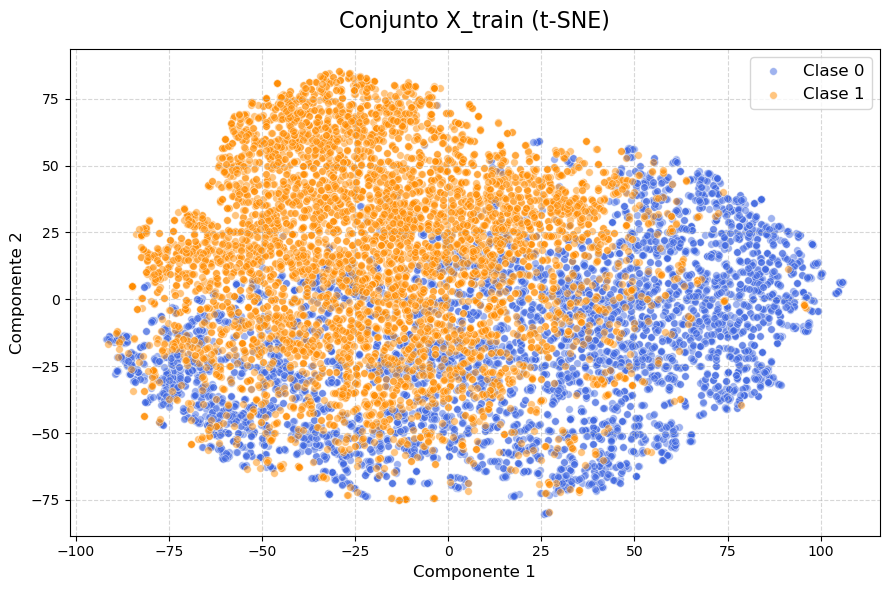

In [19]:
# Visualizar el conjunto original utilizando un scatter plot
plt.figure(figsize=(9, 6))
colores = ['royalblue', 'darkorange']  # Colores para las clases

for i, clase in enumerate([0, 1]):
    indices = Y_train == clase
    plt.scatter(
        X_train_2D[indices, 0], 
        X_train_2D[indices, 1], 
        label=f'Clase {clase}',
        alpha=0.5,  # Transparencia para observar superposición
        c=colores[i],
        edgecolor='w',  # Borde blanco para mayor claridad
        linewidth=0.5,
        s=30  # Tamaño de los puntos
    )

# Configuración del gráfico
plt.title("Conjunto X_train (t-SNE)", fontsize=16, pad=15)
plt.xlabel("Componente 1", fontsize=12)
plt.ylabel("Componente 2", fontsize=12)
plt.legend(fontsize=12, loc='upper right')
plt.grid(visible=True, linestyle='--', alpha=0.5)  # Agregar una cuadrícula suave
plt.tight_layout()
plt.show()


### Espacio latente

In [20]:
# Crear un modelo intermedio que llegue hasta la tercera capa oculta
modelo_intermedio = Model(
    inputs=modelo_completo.input,
    outputs=modelo_completo.layers[-2].output  # Salida de la capa oculta 
)

# Generar las predicciones del espacio latente para el conjunto de datos (ejemplo: X_test)
espacio_latente = modelo_intermedio.predict(X_train)

# Imprimir el número de observaciones y características
print(f"Dimensiones de X_train: {X_train.shape}")
print(f"Dimensiones del espacio latente X_train: {espacio_latente.shape}")


388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step
Dimensiones de X_train: (12408, 606)
Dimensiones del espacio latente X_train: (12408, 160)


In [21]:
# Aplicar t-SNE para reducir las dimensiones del espacio latente a 2D
tsne = TSNE(n_components=2, random_state=42)
espacio_latente_2D = tsne.fit_transform(espacio_latente)

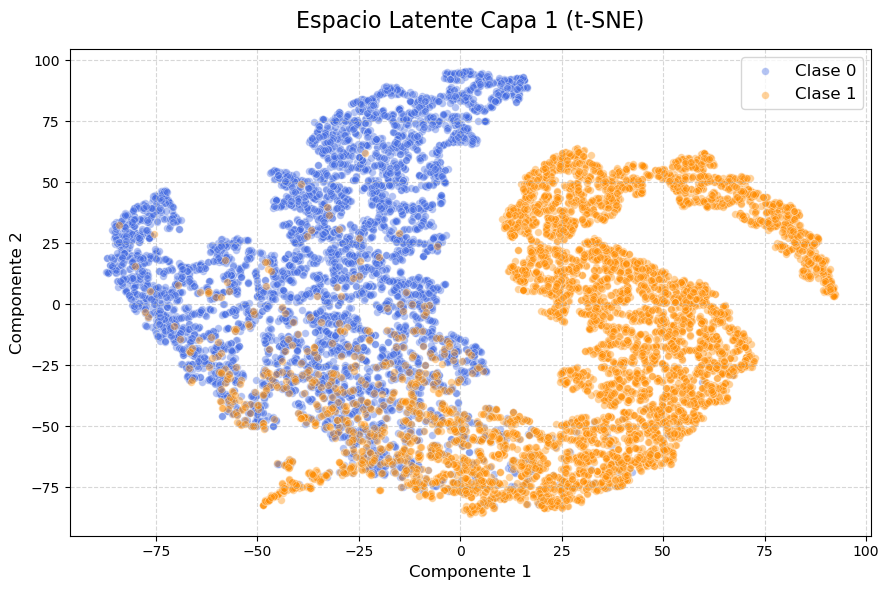

In [22]:
# Visualizar el espacio latente utilizando un scatter plot con mejoras
plt.figure(figsize=(9, 6))
colores = ['royalblue', 'darkorange']  # Colores para las clases

for i, clase in enumerate([0, 1]):
    indices = Y_train == clase
    plt.scatter(
        espacio_latente_2D[indices, 0], 
        espacio_latente_2D[indices, 1], 
        label=f'Clase {clase}',
        alpha=0.4,  # Transparencia para observar superposición
        c=colores[i],
        edgecolor='w',  # Borde blanco para mayor claridad
        linewidth=0.5,
        s=30  # Tamaño de los puntos
    )

# Configuración del gráfico
plt.title("Espacio Latente Capa 1 (t-SNE)", fontsize=16, pad=15)
plt.xlabel("Componente 1", fontsize=12)
plt.ylabel("Componente 2", fontsize=12)
plt.legend(fontsize=12, loc='upper right')
plt.grid(visible=True, linestyle='--', alpha=0.5)  # Agregar una cuadrícula suave
plt.tight_layout()
plt.show()